# version 4:
# epsilon-greedy vs. easy policy vs. softmax policy:

in this code I'm trying to compare 3 different policies taken for starling:


<b>epsilon-greedy policy:</b> explores or exploits based on a decaying exploration parameter epsilon.

<b> optimum policy:</b> a predefined heuristic decision-making rule based on deck types.

<b> softmax policy:</b> selects actions based on a probability distribution influenced by q-values and temperature.

# learning process

in each episode:

1. a set of trials is generated.

2. in each trial:

        1. a state is defined by the card value (1 to 9) and deck type (uni, low, high).
        2. policy determines the action (action == 0 if card1 < card2) or (action == 1 if card1 > card2)).
        3. reward is assigned based on the correctness of the action.
        4. q-value for the state-action pair is updated using bellman equations.

3. total reward for the episode is tracked.

4. exploration (e-greeedy) or temperature (softmax) is decayed.

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt

# creating the decks

In [10]:

uniform_deck1 = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 
                 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 
                 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 
                 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 
                 9, 9, 9, 9, 9]
uniform_deck2 = uniform_deck1.copy()

low_deck1 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 
             2, 2, 2, 2, 2, 2, 2, 2, 
             3, 3, 3, 3, 3, 3, 3, 
             4, 4, 4, 4, 4, 4, 
             5, 5, 5, 5, 5, 
             6, 6, 6, 6, 
             7, 7, 7, 
             8, 8, 
             9]
low_deck2 = low_deck1.copy()

high_deck1 = [9, 9, 9, 9, 9, 9, 9, 9, 9, 
              8, 8, 8, 8, 8, 8, 8, 8, 
              7, 7, 7, 7, 7, 7, 7, 
              6, 6, 6, 6, 6, 6, 
              5, 5, 5, 5, 5, 
              4, 4, 4, 4, 
              3, 3, 3, 
              2, 2, 
              1]
high_deck2 = high_deck1.copy()


# creating trials:

I'm creating 270 trials with the order of 45 uniform, 45 low, 45 high and then 135 mix. 

In [11]:
def create_trials():
    def make_n_trials(deck1, deck2, deck_type, n=45):
        trials = []
        for _ in range(n):
            card1 = random.choice(deck1)
            card2 = random.choice(deck2)
            while card1 == card2:
                card2 = random.choice(deck2) # card 1 and 2 can't be same cards
            trials.append((card1, card2, deck_type))
        return trials

    uniform_block = make_n_trials(uniform_deck1, uniform_deck2, "uniform", 45)
    low_block = make_n_trials(low_deck1, low_deck2, "low", 45)
    high_block = make_n_trials(high_deck1, high_deck2, "high", 45)
    
    uniform_final = make_n_trials(uniform_deck1, uniform_deck2, "uniform", 45)
    low_final = make_n_trials(low_deck1, low_deck2, "low", 45)
    high_final = make_n_trials(high_deck1, high_deck2, "high", 45)
    
    final_shuffled_block = uniform_final + low_final + high_final
    random.shuffle(final_shuffled_block)
    
    all_trials = uniform_block + low_block + high_block + final_shuffled_block
    return all_trials



def get_state_key(card1, deck_type):
    return (card1, deck_type)

# model variables

In [ ]:
q_table = {}
alpha = 0.01
gamma = 0.95

initial_reward = 10
num_episodes = 1000
reward_history = []

epsilon = 1
epsilon_min = 0.01
epsilon_decay = 0.99

initial_temperature = 1
min_temperature = 0.01
temperature_decay = 0.99

# epsilon-greedy:

In [13]:
def epsilon_greedy_policy(state):
    if state not in q_table:
        q_table[state] = [0.0, 0.0]  
    if random.random() < epsilon:
        return random.choice([0, 1])  
    else:
        return np.argmax(q_table[state])

for episode in range(num_episodes):
    trials = create_trials()
    total_reward = initial_reward

    for card1, card2, deck_type in trials:
        state = get_state_key(card1, deck_type)
        action = epsilon_greedy_policy(state)

        if (action == 0 and card1 < card2) or (action == 1 and card1 > card2):
            r = 0.5
        else:
            r = -0.5

        if state not in q_table:
            q_table[state] = [0.0, 0.0]
        current_q = q_table[state][action]
        max_next_q = max(q_table[state])  
        q_table[state][action] = current_q + alpha * (r + gamma * max_next_q - current_q)

        total_reward += r

    reward_history.append(total_reward)

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay


# optimum policy:

 if the deck type is uniform, if card1<5, decide card1<card2; if the card1>5, decide card1>card2, if card1 =5 decide randomly.


 if the deck is low, if card1< 3, decide card1<card2, if the card1> 3 card1>card2, if card1= 3 decide randomly.


if the deck is high, if card1< 7, decide card1<card2, if the card1> 7 card1>card2, if card1= 7 decide randomly.

In [14]:

def easy_policy(card1, deck_type):
    if deck_type == "uniform":
        if card1 < 5:
            return 0
        elif card1 > 5:
            return 1
        else:
            return random.choice([0, 1])
    elif deck_type == "low":
        if card1 < 3:
            return 0
        elif card1 > 3:
            return 1
        else:
            return random.choice([0, 1])
    elif deck_type == "high":
        if card1 < 7:
            return 0
        elif card1 > 7:
            return 1
        else:
            return random.choice([0, 1])

reward_history_easy = []

for episode in range(num_episodes):
    trials = create_trials()
    total_reward_easy = initial_reward

    for card1, card2, deck_type in trials:
        state = get_state_key(card1, deck_type)
        action = easy_policy(card1, deck_type)

        if (action == 0 and card1 < card2) or (action == 1 and card1 > card2):
            r = 0.5
        else:
            r = -0.5

        if state not in q_table:
            q_table[state] = [0.0, 0.0]
        current_q = q_table[state][action]
        max_next_q = max(q_table[state])  
        q_table[state][action] = current_q + alpha * (r + gamma * max_next_q - current_q)

        total_reward_easy += r

    reward_history_easy.append(total_reward_easy)


# softmax:

In [15]:
def softmax_policy(state, temperature):
    if state not in q_table:
        q_table[state] = [0.0, 0.0]
    q_values = q_table[state]
    exp_q = np.exp(np.array(q_values) / temperature)
    probabilities = exp_q / np.sum(exp_q)
    return np.random.choice([0, 1], p=probabilities)

reward_history_softmax = []

temperature = initial_temperature

for episode in range(num_episodes):
    trials = create_trials()
    total_reward_softmax = initial_reward

    for card1, card2, deck_type in trials:
        state = get_state_key(card1, deck_type)
        action = softmax_policy(state, temperature)

        if (action == 0 and card1 < card2) or (action == 1 and card1 > card2):
            r = 0.5
        else:
            r = -0.5

        if state not in q_table:
            q_table[state] = [0.0, 0.0]
        current_q = q_table[state][action]
        max_next_q = max(q_table[state])  
        q_table[state][action] = current_q + alpha * (r + gamma * max_next_q - current_q)

        total_reward_softmax += r

    reward_history_softmax.append(total_reward_softmax)

    # Decay temperature
    temperature = max(min_temperature, temperature * temperature_decay)


# e-greedy vs easy vs. softmax:

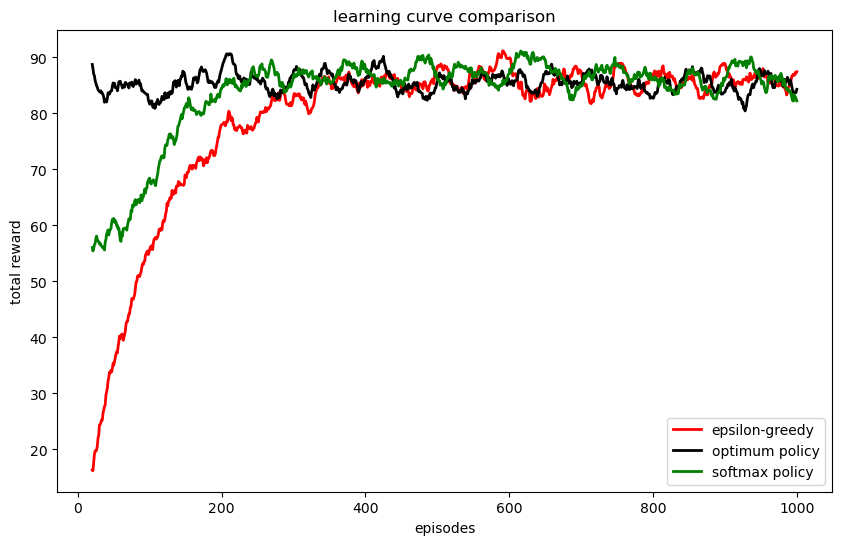

In [16]:
plt.figure(figsize=(10, 6))

window_size = 20
moving_avg = np.convolve(reward_history, np.ones(window_size) / window_size, mode='valid')
moving_avg_easy = np.convolve(reward_history_easy, np.ones(window_size) / window_size, mode='valid')
moving_avg_softmax = np.convolve(reward_history_softmax, np.ones(window_size) / window_size, mode='valid')

plt.plot(range(window_size, num_episodes + 1), moving_avg, 
         label=f'epsilon-greedy', color='red', linewidth=2)
plt.plot(range(window_size, num_episodes + 1), moving_avg_easy, 
         label=f'optimum policy', color='black', linewidth=2)
plt.plot(range(window_size, num_episodes + 1), moving_avg_softmax, 
         label=f'softmax policy', color='green', linewidth=2)

plt.xlabel('episodes')
plt.ylabel('total reward')
plt.title('learning curve comparison')
plt.legend()
plt.show()

# explanation of results:

<b>optimum policy:</b>

 1. if the deck type is uniform, if card1<5, decide card1<card2; if the card1>5, decide card1>card2, if card1 =5 decide randomly.

 2. if the deck is low, if card1< 3, decide card1<card2, if the card1> 3 card1>card2, if card1= 3 decide randomly.
 
 3. if the deck is high, if card1< 7, decide card1<card2, if the card1> 7 card1>card2, if card1= 7 decide randomly.



<b>e-greedy:</b>

initially explores heavily and converges to optimal policy over time.



<b>softmax:</b> 

takes more episodes to reach to the optimum policy.



## both e-greedy and softmax have reached to the optimum policy which is a good sign and means that the models are learning well.